# Tech Challenge - Fase II

**Grupo 2:**
* Leandro Soares da Silva RM:352511
* Marcos Barbosa da Silva RM:352571


## O Desafio:

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base.

Para isso utilize a base de dados contida no site da investing ou a biblioteca Yahoo Finance, selecione o período “diário”, com o intervalo de tempo que achar adequado.

**Você precisará demonstrar para o time de investimentos:**
1. O modelo com o storytelling, desde a captura do dado até a entrega do modelo

2. Justificar a técnica utilizada

3. Atingir uma acuracidade adequada (acima de 70%).
        

# 1. Imports

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
from prophet import Prophet
from sklearn.metrics import r2_score

import yfinance as yf

#ARIMA E SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

#Rede Neural
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from pmdarima import auto_arima


# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


# 2. Extração dos dados

In [54]:
symbol = 'BOVA11.SA'
start_date = '2018-01-01'
end_date = '2024-03-09'

df = yf.download(symbol, start=start_date, end=end_date, period='D')

[*********************100%%**********************]  1 of 1 completed


In [55]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,74.000000,75.230003,74.000000,75.099998,75.099998,2292470
2018-01-03,75.000000,75.769997,74.900002,75.300003,75.300003,3765200
2018-01-04,75.540001,76.440002,75.510002,76.000000,76.000000,2245750
2018-01-05,76.000000,76.440002,75.559998,76.440002,76.440002,2288790
2018-01-08,76.330002,76.760002,75.930000,76.760002,76.760002,2544400


## 2.1 Selecionando apenas as colunas de interesse

In [56]:
df = df[['Close']].copy()
df.head()

,Close
Date,
2018-01-02,75.099998
2018-01-03,75.300003
2018-01-04,76.000000
2018-01-05,76.440002
2018-01-08,76.760002


# 3. Análise Exploratória

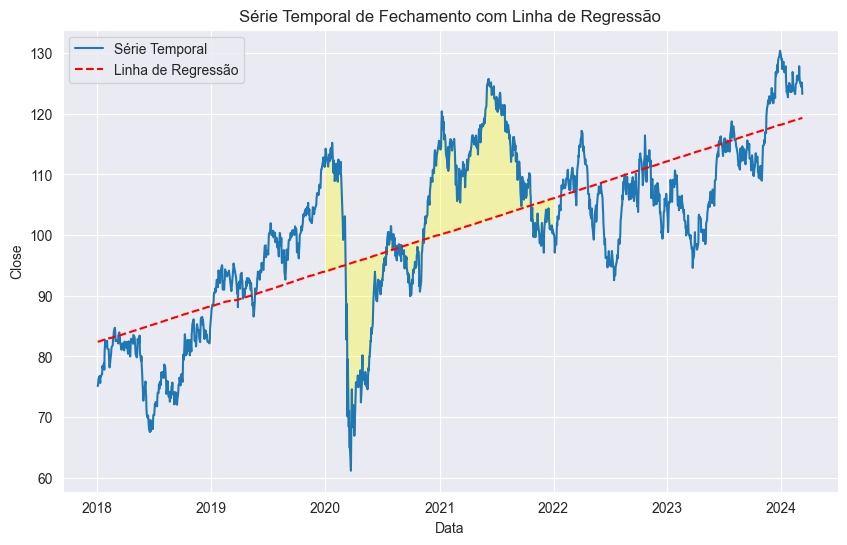

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Ajustando uma linha de regressão linear
x = np.arange(len(df.index))
y = df['Close'].values
coefficients = np.polyfit(x, y, 1)
polynomial = np.poly1d(coefficients)
y_fit = polynomial(x)

# Plotando o gráfico
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], linestyle='-', label='Série Temporal')
plt.plot(df.index, y_fit, linestyle='--', color='red', label='Linha de Regressão')

# Destacando o período de 2020 a 2021 com um círculo
plt.fill_between(df.index, y_fit, df['Close'], where=(df.index >= '2020-01-01') & (df.index <= '2021-12-31'), color='yellow', alpha=0.3)

plt.title('Série Temporal de Fechamento com Linha de Regressão')
plt.xlabel('Data')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()


A base da Bolsa de Valores de São Paulo foi diretamente impactada pela pandemia de COVID-19, como evidenciado no gráfico acima. Após a normalização desse cenário no primeiro semestre de 2022, as bolsas retomaram suas atividades com menos volatilidade sazonal.

## 3.1 Decomposição da Série

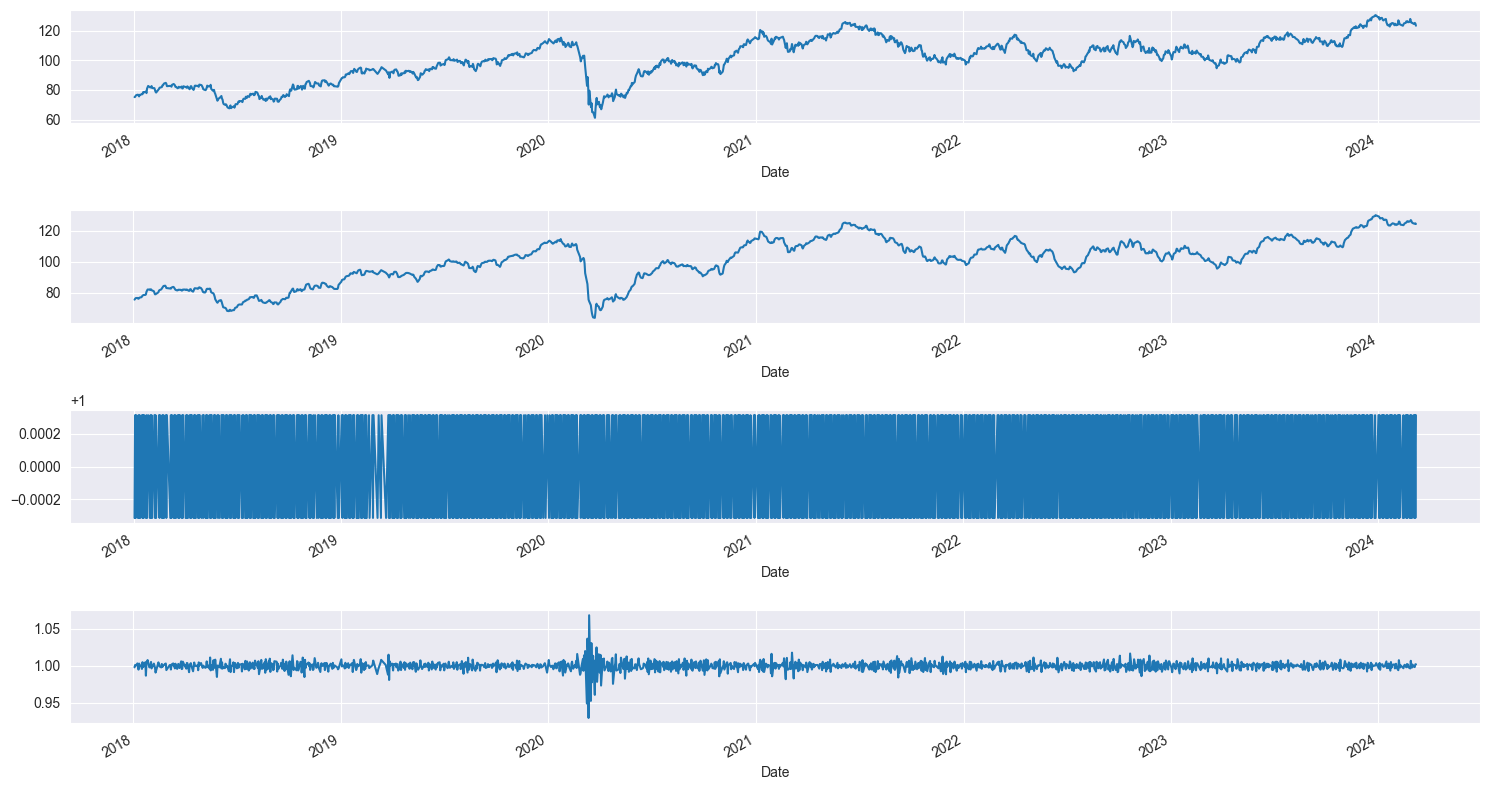

In [58]:
seasonplot = seasonal_decompose(df, model='multiplicative', period=2) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

## 3.2 Teste adfuller
Métado para um teste estatístico com a finalidade de aceitar/recusar a hipótese da série ser estacionária 

H0 - Hipótese nula (Não é estacionária)
H1 - Hipótese alternativa (a série é estacionária)

**Quanto maior o p-value, mais evidencia contra a hipótese nula se tem**

**Rejeitamos a hipótese nula se o p-value for menor que 0.05, ou seja, estamos trabalhando com um intervalode confiança de 95%**

In [59]:
# Teste na base completa
sns.set_style('darkgrid')
X = df.Close.values

result = adfuller(X)

print('Teste ADF')
print(f'Teste estatístico: {result[0]}')
print(f'P-value: {result[1]}')
print(f'Valores criticos: ')

for key, value in result[4].items():
    print(f'\t {key}: {value}')

Teste ADF
Teste estatístico: -2.2116971823235074
P-value: 0.20202747926035985
Valores criticos: 
	 1%: -3.4346938104971554
	 5%: -2.863458518103151
	 10%: -2.567791394384679


O valor-p não é menor que 0.05 e o teste estatístico é maior que os valores críticos de 1%, 5% e 10%. Então, não dá pra rejeitar a hipótese nula (H0).

## 3.3 Média Móvel

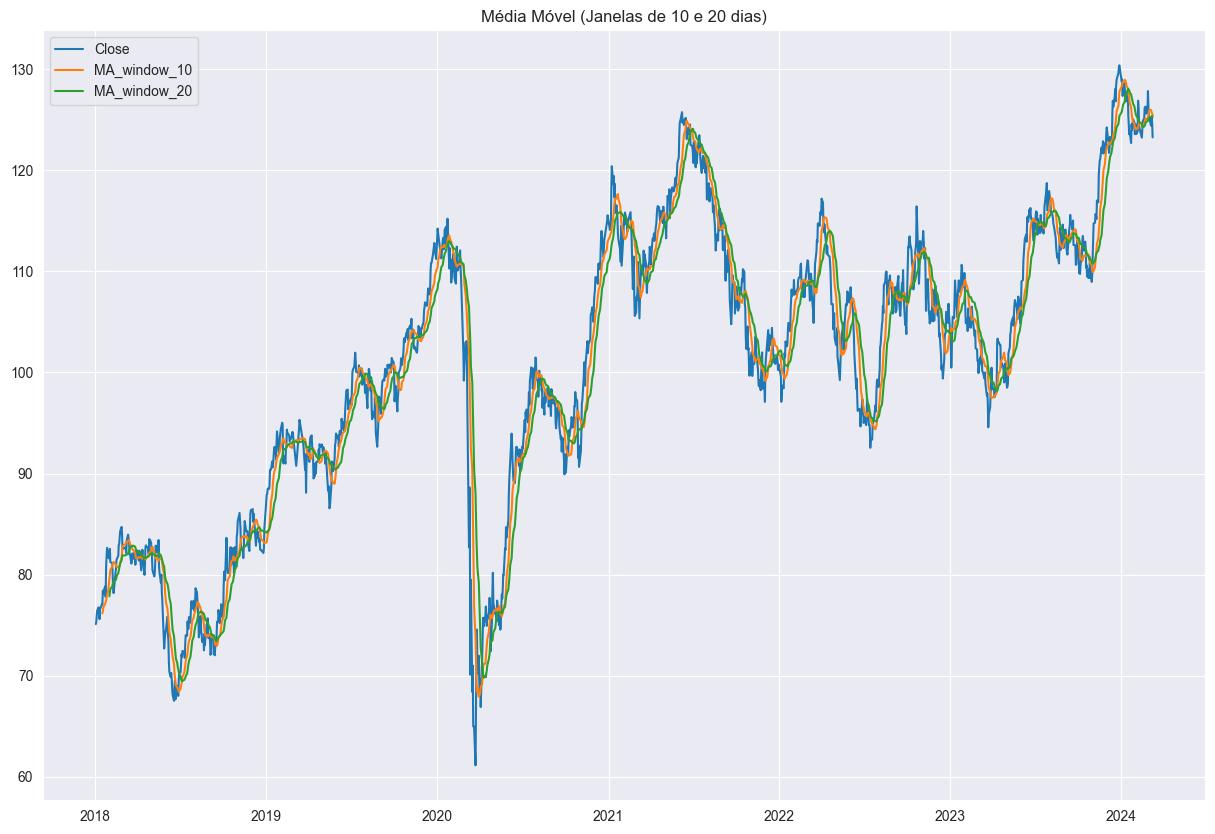

In [60]:
#Com Janelas de 10 e 20 dias
df['MA_window_10'] = df['Close'].rolling(10).mean().shift()
df['MA_window_20'] = df['Close'].rolling(20).mean().shift()

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_window_10'], label='MA_window_10')
plt.plot(df['MA_window_20'], label='MA_window_20')
plt.title('Média Móvel (Janelas de 10 e 20 dias)')
plt.legend(loc=2)
plt.show()

A princípio, a Média Móvel parece explicar adequadamente os dados da série temporal. Contudo, ao analisarmos os gráficos mais de perto, percebemos uma grande discrepância entre a média móvel e os valores reais.

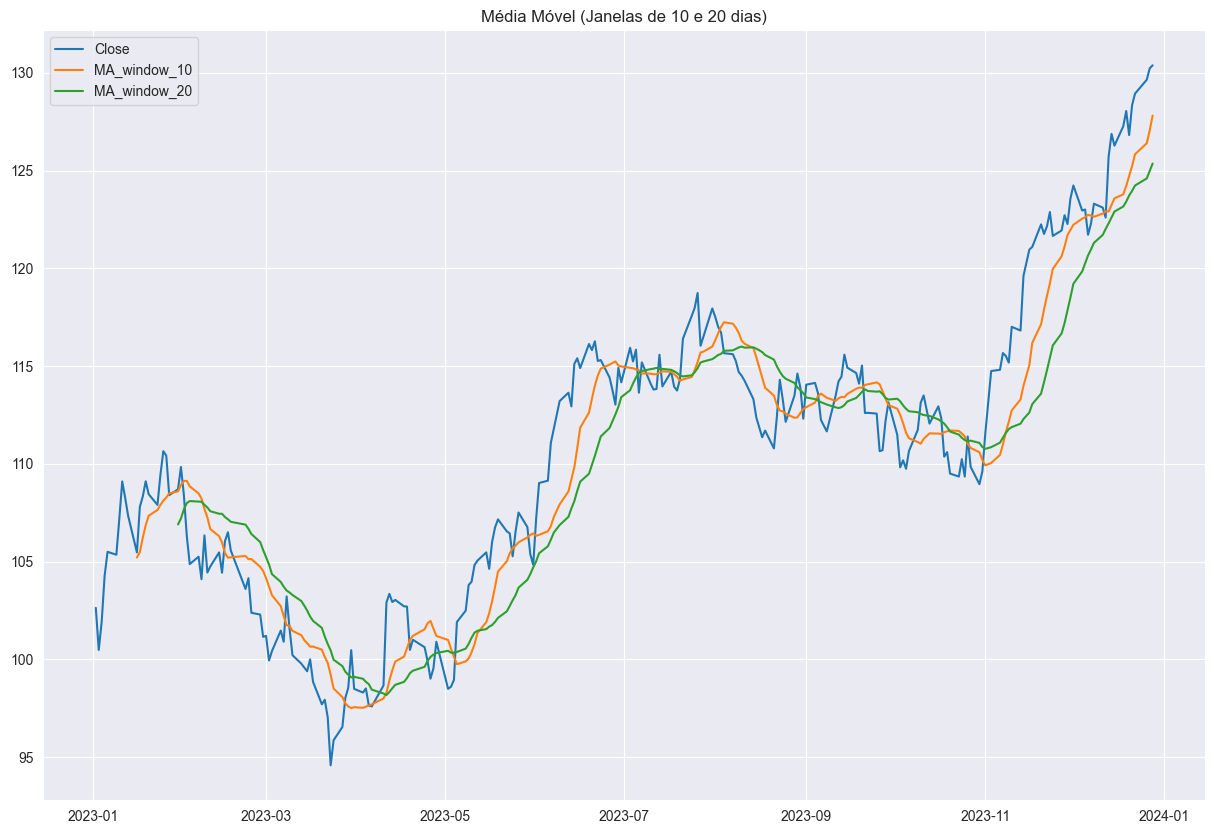

In [61]:
df_2023 = df.loc['2023-01-01':'2023-12-31']
df_2023['MA_window_10'] = df_2023['Close'].rolling(10).mean().shift()
df_2023['MA_window_20'] = df_2023['Close'].rolling(20).mean().shift()
df_2023

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df_2023['Close'], label='Close')
plt.plot(df_2023['MA_window_10'], label='MA_window_10')
plt.plot(df_2023['MA_window_20'], label='MA_window_20')
plt.title('Média Móvel (Janelas de 10 e 20 dias)')
plt.legend(loc=2)
plt.show()

# 4. Modelos e Testes

## 4.1 SARIMAX

In [62]:
fit_arima = auto_arima(df[['Close']], d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                       seasonal=True,
                       m=6,
                       D=1,
                       start_P=1,
                       start_Q=1,
                       max_P=2,
                       max_Q=2,
                       information_criterion='aic',
                       trace=True,
                       error_action='ignore',
                       stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=6634.385, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=6152.906, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=inf, Time=1.31 sec
 ARIMA(1,1,0)(0,1,0)[6]             : AIC=6586.545, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[6]             : AIC=5937.038, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=inf, Time=2.79 sec
 ARIMA(1,1,0)(1,1,1)[6]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(2,1,0)[6]             : AIC=5955.966, Time=0.29 sec
 ARIMA(2,1,0)(2,1,0)[6]             : AIC=5938.954, Time=0.35 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=5938.991, Time=0.51 sec
 ARIMA(0,1,1)(2,1,0)[6]             : AIC=5937.818, Time=0.35 sec
 ARIMA(2,1,1)(2,1,0)[6]             : AIC=5940.296, Time=1.23 sec
 ARIMA(1,1,0)(2,1,0)[6] intercept   : AIC=5939.030, Time=0.75 sec

Best model:  ARIMA(1,1,0)(2,1,0)[6]          
Total 

In [63]:
model = SARIMAX(df[['Close']], order=(1,1,0), seasonal_order=(2,1,0,6))
result_sarimax = model.fit()



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99804D+00    |proj g|=  1.62779D-01


 This problem is unconstrained.



At iterate    5    f=  1.95549D+00    |proj g|=  2.56676D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   5.466D-06   1.955D+00
  F =   1.9554873635222034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [64]:
df['yhat_SARIMAX'] = result_sarimax.predict()

,Close,MA_window_10,MA_window_20,yhat_SARIMAX
Date,,,,
2018-01-02,75.099998,NaN,NaN,0.000000
2018-01-03,75.300003,NaN,NaN,75.099978
2018-01-04,76.000000,NaN,NaN,75.300005
2018-01-05,76.440002,NaN,NaN,75.999999
2018-01-08,76.760002,NaN,NaN,76.440001
...,...,...,...,...
2024-03-04,124.500000,125.978000,125.2820,125.323237
2024-03-05,124.400002,125.914000,125.2790,126.026133
2024-03-06,125.150002,125.735000,125.3200,125.048860


### 4.1.1 MAPE

In [72]:
# Renomear colunas para 'ds' e 'y'

valores_reais = pd.DataFrame()
valores_reais['ds'] = df.index
valores_reais['y'] = df['Close'].values  


previsao = pd.DataFrame()
previsao['ds'] = df.index
previsao['yhat'] = df['yhat_SARIMAX'].values  



# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 1.38%


## 4.2 Prophet

Ajustando o dataframe para usar no modelo

In [81]:
df.index.name = 'ds'
df.rename(columns={'Close':'y'}, inplace = True)
df.reset_index(inplace=True)
df.head()

,ds,y,MA_window_10,MA_window_20,yhat_SARIMAX
0,2018-01-02,75.099998,NaN,NaN,0.000000
1,2018-01-03,75.300003,NaN,NaN,75.099978
2,2018-01-04,76.000000,NaN,NaN,75.300005
3,2018-01-05,76.440002,NaN,NaN,75.999999
4,2018-01-08,76.760002,NaN,NaN,76.440001


### 4.2.1 Separando as base de treino e teste

In [82]:
train_data = df[['ds','y']].sample(frac=0.8, random_state=0)
test_data = df[['ds','y']].drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (1213, 2)
testing data size : (303, 2)


### 4.2.2 Treinando o modelo com tecnica de GridSearch

In [83]:
from sklearn.model_selection import ParameterGrid
import numpy as np

# Função para calcular o MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Defina uma lista de hiperparâmetros para ajustar
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1],
    'seasonality_prior_scale': [1.0, 5.0, 10.0],
    'holidays_prior_scale': [1.0, 5.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative'],
    'growth': ['linear'],
    'changepoint_range': [0.8, 0.9],
    'uncertainty_samples': [100, 500, 1000]
}

# Lista para armazenar os resultados da busca em grade
results = []

# Iterar sobre todas as combinações de hiperparâmetros
for params in ParameterGrid(param_grid):
    # Criar o modelo com os hiperparâmetros especificados
    modelo = Prophet(daily_seasonality=True, **params)
    
    # Treinar o modelo
    modelo.fit(train_data)
    
    # Fazer previsões
    future = modelo.make_future_dataframe(periods=30, freq='D')
    previsao = modelo.predict(future)
    
    # Calcular o MAPE
    mape = calculate_mape(test_data['y'], previsao[-30:]['yhat'])
    
    # Armazenar os resultados
    results.append((params, mape))

# Encontrar os melhores hiperparâmetros com base no menor MAPE
best_params, best_mape = min(results, key=lambda x: x[1])

print("Melhores hiperparâmetros:", best_params)
print("Melhor MAPE:", best_mape)

16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1]

Melhores hiperparâmetros: {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.8, 'growth': 'linear', 'holidays_prior_scale': 1.0, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0, 'uncertainty_samples': 100}
Melhor MAPE: 4.9026360815703445


In [84]:
# Criando o modelo com os hiperparâmetros configurados
modelo = Prophet(daily_seasonality=True, **best_params)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(dataFramefuture)
previsao.head()

16:35:24 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-02,75.534927,69.673819,91.900803,75.534927,75.534927,6.232870,6.232870,6.232870,1.784846,...,0.448237,0.448237,0.448237,3.999786,3.999786,3.999786,0.0,0.0,0.0,81.767796
1,2018-01-03,75.561072,69.188973,92.362710,75.561072,75.561072,5.831733,5.831733,5.831733,1.784846,...,0.009585,0.009585,0.009585,4.037302,4.037302,4.037302,0.0,0.0,0.0,81.392805
2,2018-01-04,75.587218,73.058717,91.647793,75.587218,75.587218,5.753531,5.753531,5.753531,1.784846,...,-0.115481,-0.115481,-0.115481,4.084167,4.084167,4.084167,0.0,0.0,0.0,81.340750
3,2018-01-05,75.613364,69.287465,92.367070,75.613364,75.613364,6.054960,6.054960,6.054960,1.784846,...,0.130262,0.130262,0.130262,4.139853,4.139853,4.139853,0.0,0.0,0.0,81.668325
4,2018-01-08,75.691802,72.048443,91.268470,75.691802,75.691802,6.109321,6.109321,6.109321,1.784846,...,-0.026390,-0.026390,-0.026390,4.350865,4.350865,4.350865,0.0,0.0,0.0,81.801122


### 4.2.3 Plot do Gráfico do Modelo

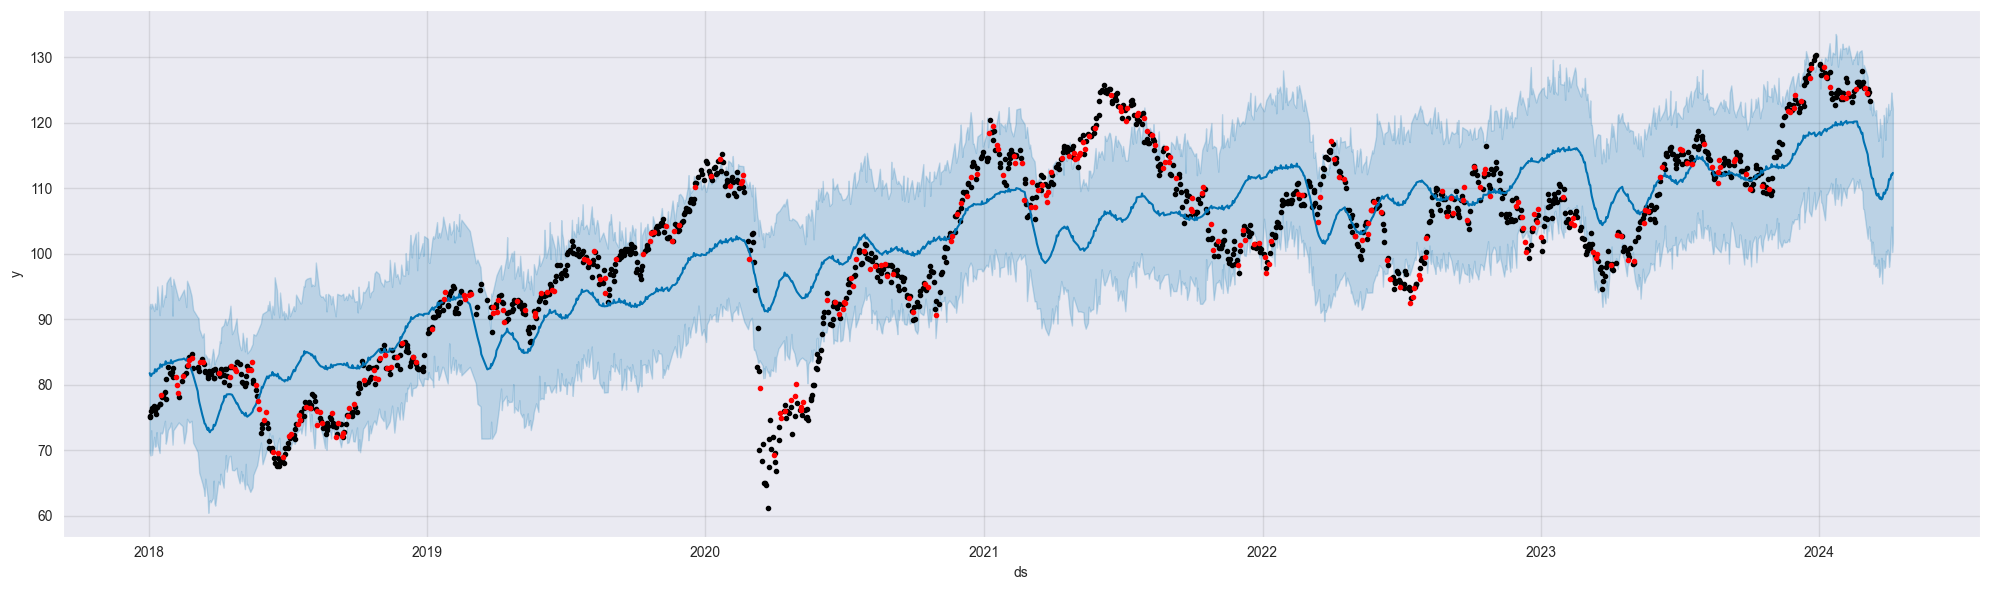

In [86]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

### 4.2.4 MAPE

In [87]:

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 7.00%


### 4.2.5 Cross validation

In [89]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')

from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

  0%|          | 0/7 [00:00<?, ?it/s]

16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:41 - cmdstanpy - INFO - Chain [1] done processing
16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:41 - cmdstanpy - INFO - Chain [1] done processing
16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:41 - cmdstanpy - INFO - Chain [1] done processing
16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:41 - cmdstanpy - INFO - Chain [1] done processing
16:41:41 - cmdstanpy - INFO - Chain [1] start processing
16:41:41 - cmdstanpy - INFO - Chain [1] done processing
16:41:42 - cmdstanpy - INFO - Chain [1] start processing
16:41:42 - cmdstanpy - INFO - Chain [1] done processing
16:41:42 - cmdstanpy - INFO - Chain [1] start processing
16:41:42 - cmdstanpy - INFO - Chain [1] done processing


,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,213.754418,14.620343,10.721255,0.116384,0.081337,0.107667,0.550725
1,38 days,211.678993,14.549192,10.706993,0.115390,0.079632,0.107165,0.557971
2,39 days,210.974083,14.524947,10.710610,0.115000,0.079632,0.107037,0.559420
3,40 days,211.286063,14.535682,10.731509,0.114835,0.079632,0.107093,0.557971
4,41 days,213.530573,14.612685,10.844873,0.115689,0.081337,0.107811,0.550725
...,...,...,...,...,...,...,...,...
324,361 days,309.177819,17.583453,15.000259,0.134660,0.128454,0.133201,0.340580
325,362 days,315.709167,17.768207,15.205558,0.136497,0.132131,0.134895,0.336232
326,363 days,322.086752,17.946776,15.349514,0.137812,0.132131,0.135946,0.331884
327,364 days,325.447345,18.040159,15.440734,0.138660,0.132131,0.136753,0.328502


## 4.3 LSTM

### 4.3.1 Normalizando os dados

In [91]:
close_data = df['y'].values
close_data = close_data.reshape(-1,1) #transformar em array

In [93]:
split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['ds'][:split]
date_test = df['ds'][split:]

print(len(close_train))
print(len(close_test))

1212
304


In [94]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [95]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 681.0878 - mean_squared_error: 681.5718
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7972 - mean_squared_error: 14.6082
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.6804 - mean_squared_error: 15.3114
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7795 - mean_squared_error: 8.7630
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.3518 - mean_squared_error: 10.4369
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.2951 - mean_squared_error: 15.2778
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.8451 - mean_squared_error: 6.8343
Epoch 8/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7425 - mean_squared_error: 8.5215
Epoch 9/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.9244 - mean_squared_error: 5.6805
Epoch 10/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2711 - mean_squared_error: 4.3138
Epoch 11/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

In [96]:
# Avaliando o modelo nos dados de teste
mse = model.evaluate(test_generator, verbose=1)
print("Erro Quadrático Médio", mse[0])

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 4.2858 - mean_squared_error: 4.2858
Erro Quadrático Médio 4.4545111656188965


### 4.3.1 MAPE

In [101]:
# Fazer previsões usando o modelo treinado
predictions = model.predict(test_generator)

# Desfazer o scaling das previsões e dos valores reais, se necessário

# Calcular o erro absoluto percentual (APE) para cada ponto de dados
APE = np.abs((predictions - close_test[look_back:]) / close_test[look_back:]) * 100

# Calcular a média do erro absoluto percentual (MAPE)
MAPE = np.mean(APE)

print("Mean Absolute Percentage Error (MAPE):", MAPE)

294/294 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
Mean Absolute Percentage Error (MAPE): 1.4961315696110211


# 5. Resultados
Com o intuito de enfrentar o desafio proposto, importamos as bibliotecas necessárias para visualização e tratamento de dados. Realizamos a extração dos dados solicitados, considerando o valor de fechamento da Bovespa, utilizando a biblioteca "yfinance". O período abrangido foi de 2018 a 2024, visando obter uma base abrangente de registros, que inclui dados da pandemia de 2019.

Durante a análise exploratória, observamos uma significativa variação nos valores durante o período da pandemia, o que era esperado dadas as circunstâncias. Além disso, identificamos padrões sazonais, embora uma análise mais detalhada em intervalos menores possa fornecer insights adicionais. A tendência clara da série foi confirmada através do teste de AdFuller, mesmo não rejeitando a hipótese nula.

No que diz respeito aos modelos construídos, optamos por SARIMAX, Prophet e LSTM, aplicando técnicas aprendidas durante o curso. O SARIMAX apresentou o menor MAPE, sugerindo uma boa capacidade de previsão. No entanto, reconhecemos a necessidade de realizar mais testes para avaliar sua robustez em prever dados futuros.

O modelo Prophet, apesar de um MAPE variando entre 13% e 7%, mostrou-se mais seguro devido à validação cruzada realizada e à compreensão do intervalo de variação do MAPE. Isso sugere que o modelo pode ser mais confiável em diferentes contextos e períodos.

Por fim, o LSTM, embora tenha exigido normalização dos dados e tenha obtido um MAPE próximo ao do SARIMAX, pode ser explorado mais profundamente em futuros estudos para avaliar seu desempenho em diferentes configurações e períodos.

Concluímos que, embora o SARIMAX tenha sido o destaque em termos de desempenho inicial, o modelo Prophet parece ser a escolha mais segura devido à sua capacidade de generalização e estabilidade, conforme demonstrado pela validação cruzada. No entanto, recomenda-se realizar mais testes e refinamentos em todos os modelos para uma compreensão mais completa de seu desempenho e capacidade de previsão em cenários futuros.